In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Download Data

In [2]:
etf_indicators_list = ['SPY']


first_indicator_name = etf_indicators_list[0]
first_indicator_filename = first_indicator_name+'.csv'
all_raw_data = pd.read_csv(first_indicator_filename)

open_name = first_indicator_name+'_open'
high_name = first_indicator_name+'_high'
low_name = first_indicator_name+'_low'
close_name = first_indicator_name+'_close'
adj_close_name = first_indicator_name+'_adj_close'
volume_name = first_indicator_name+'_volume'

all_raw_data = all_raw_data.rename(columns = {"Date":"Date",\
                           "Open":open_name,\
                           "High":high_name,\
                           'Low':low_name,\
                           'Close':close_name,\
                           'Adj Close':adj_close_name,\
                           'Volume':volume_name})


for index in range(1,len(etf_indicators_list)):
    
    name = etf_indicators_list[index]
    filename = name+'.csv'
    data = pd.read_csv(filename)
    
    open_name = name+'_open'
    high_name = name+'_high'
    low_name = name+'_low'
    close_name = name+'_close'
    adj_close_name = name+'_adj_close'
    volume_name = name+'_volume'
    
    data = data.rename(columns = {"Date":"Date",\
                           "Open":open_name,\
                           "High":high_name,\
                           'Low':low_name,\
                           'Close':close_name,\
                           'Adj Close':adj_close_name,\
                           'Volume':volume_name})
    
    all_raw_data = pd.merge(all_raw_data,data,how = 'inner',on = 'Date')

In [3]:
all_raw_data

,Date,SPY_open,SPY_high,SPY_low,SPY_close,SPY_adj_close,SPY_volume
0,1993-01-29,43.968750,43.968750,43.750000,43.937500,25.884184,1003200
1,1993-02-01,43.968750,44.250000,43.968750,44.250000,26.068277,480500
2,1993-02-02,44.218750,44.375000,44.125000,44.343750,26.123499,201300
3,1993-02-03,44.406250,44.843750,44.375000,44.812500,26.399649,529400
4,1993-02-04,44.968750,45.093750,44.468750,45.000000,26.510111,531500
...,...,...,...,...,...,...,...
7085,2021-03-19,389.880005,391.570007,387.149994,389.480011,389.480011,112777800
7086,2021-03-22,390.029999,394.070007,389.970001,392.589996,392.589996,73778600
7087,2021-03-23,391.910004,393.459991,388.660004,389.500000,389.500000,90686600
7088,2021-03-24,391.000000,392.750000,387.470001,387.519989,387.519989,97449100


In [4]:
stock_name = 'SPY'
stock_column_name = stock_name+'_adj_close'
#stock_column_name = 'close'
raw_data_for_single_stock = pd.DataFrame()
raw_data_for_single_stock['price'] = all_raw_data[stock_column_name]

# Define the idea of state in a Markov process

For the Markov process, we are trying to build a stochastic matrix. Before building the matrix,
we need to define what a state is in this Markov process. Here, we construct a ratio between stock price and moving average. We then discretize the ratio into discrete states of this Markov process. 

In [5]:
mvs = [10] #mv means moving average

In [6]:

for period in mvs:
    ewm = raw_data_for_single_stock['price'].ewm(span = period).mean()
    ratio = raw_data_for_single_stock['price']/ewm
    raw_data_for_single_stock['ewm_'+str(period)] = ratio

In [7]:
raw_data_for_single_stock

,price,ewm_10
0,25.884184,1.000000
1,26.068277,1.003188
2,26.123499,1.003171
3,26.399649,1.009195
4,26.510111,1.009529
...,...,...
7085,389.480011,0.997669
7086,392.589996,1.004606
7087,389.500000,0.997298
7088,387.519989,0.993632


In [8]:
cleaned_ewm = raw_data_for_single_stock.iloc[max(mvs):,:]
cleaned_ewm = cleaned_ewm.reset_index(drop=True)
cleaned_ewm

,price,ewm_10
0,26.270786,0.996870
1,25.608032,0.977243
2,25.589626,0.981058
3,25.571209,0.984093
4,25.663250,0.989976
...,...,...
7075,389.480011,0.997669
7076,392.589996,1.004606
7077,389.500000,0.997298
7078,387.519989,0.993632


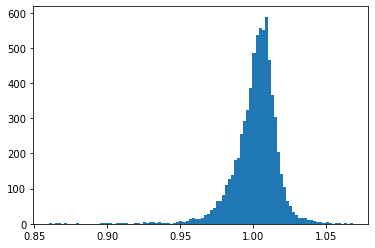

In [9]:
mv_ratio_distribution = cleaned_ewm['ewm_'+str(mvs[0])].tolist()
plt.hist(mv_ratio_distribution,bins = 100)
plt.show()

Given the distribution of the ratio of stock price to moving average, we can select several cut off points for discretization. 

In [10]:
mv_ratio_mean = np.mean(mv_ratio_distribution)
mv_ratio_std = np.std(mv_ratio_distribution)

num_of_break_points = 10
max_std = 3
min_std = -3
std_range = max_std-min_std

std_break_points = []
for index in range(0,num_of_break_points):
    break_point = min_std+(std_range)/(num_of_break_points-1)*index
    std_break_points.append(break_point)

In [11]:
std_break_points

[-3.0,
 -2.3333333333333335,
 -1.6666666666666667,
 -1.0,
 -0.3333333333333335,
 0.33333333333333304,
 1.0,
 1.666666666666666,
 2.333333333333333,
 3.0]

In [12]:
break_points = []
for entry in std_break_points:
    break_point = entry*mv_ratio_std+mv_ratio_mean
    break_points.append(break_point)

In [13]:
break_points

[0.9567067751139978,
 0.9667022963040589,
 0.97669781749412,
 0.9866933386841811,
 0.9966888598742422,
 1.0066843810643031,
 1.0166799022543644,
 1.0266754234444253,
 1.0366709446344866,
 1.0466664658245477]

In [14]:
def value_to_state_index(current_value,break_points):
    
    for index in range(0,len(break_points)):
        break_point = break_points[index]
        
        if current_value<break_point:
            return index
    
    return len(break_points)

In [15]:
transition_matrix_dict = {}

for future_index in range(1,20):
    
    size_of_transition_matrix = len(break_points)+1
    transition_matrix = np.ones((size_of_transition_matrix,size_of_transition_matrix))
    
    for time_index in range(future_index,len(mv_ratio_distribution)):
        previous_data = mv_ratio_distribution[time_index-future_index]
        today_data = mv_ratio_distribution[time_index]

        row = value_to_state_index(previous_data,break_points)

        column = value_to_state_index(today_data,break_points)

        transition_matrix[row,column] += 1
        
    for row in range(0,transition_matrix.shape[0]):
        transition_matrix[row] = transition_matrix[row]/sum(transition_matrix[row])

    transition_matrix_dict[future_index] = transition_matrix

# Build the Markov stochastic matrix
We use maximum likelihood estimate to estimate the Markov stochastic matrix for different days into the future. 
In particular, the days are 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,and 19. 

transition for  1  day into the future


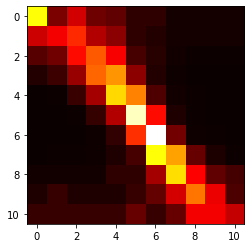

transition for  2  day into the future


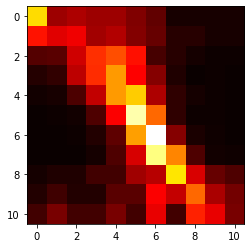

transition for  3  day into the future


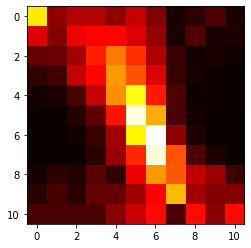

transition for  4  day into the future


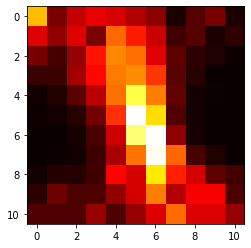

transition for  5  day into the future


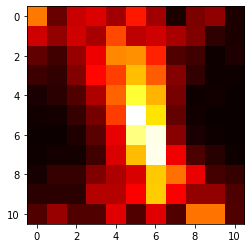

transition for  6  day into the future


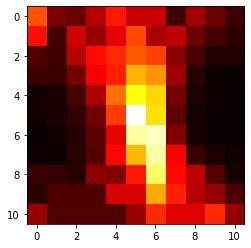

transition for  7  day into the future


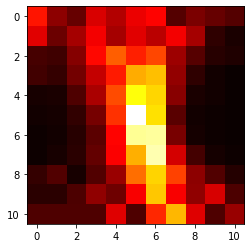

transition for  8  day into the future


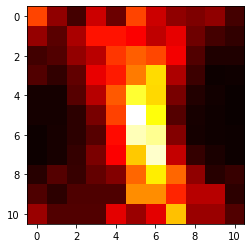

transition for  9  day into the future


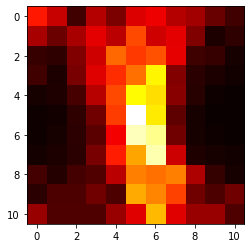

transition for  10  day into the future


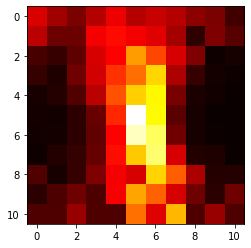

transition for  11  day into the future


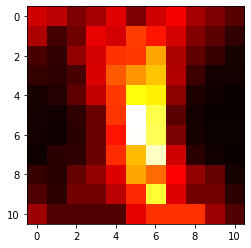

transition for  12  day into the future


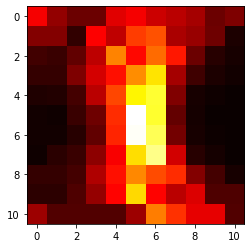

transition for  13  day into the future


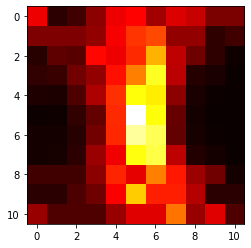

transition for  14  day into the future


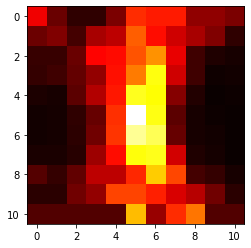

transition for  15  day into the future


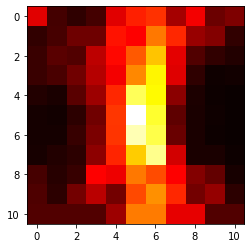

transition for  16  day into the future


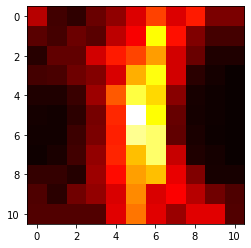

transition for  17  day into the future


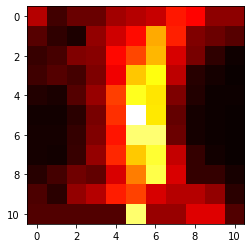

transition for  18  day into the future


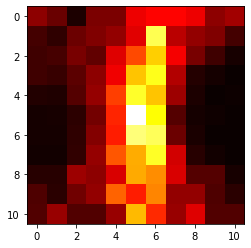

transition for  19  day into the future


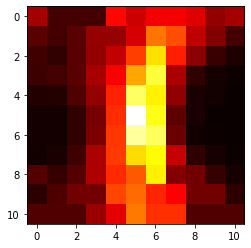

In [16]:
np.set_printoptions(suppress=True)
import seaborn as sns

for key in transition_matrix_dict.keys():
    print('transition for ',str(key), ' day into the future')
    plt.imshow(transition_matrix_dict[key], cmap='hot', interpolation='nearest')
    plt.show()
    #print(np.diagonal(transition_matrix_dict[key]))
    #print(transition_matrix_dict[key][-2,:])

In [17]:
#assign reward to each state
#the reward is a column matrix
reward_assignment = np.zeros((len(break_points)+1,1))
for row in range(0,reward_assignment.shape[0]):
    reward_assignment[row][0] = row
print(reward_assignment)

[[ 0.]
 [ 1.]
 [ 2.]
 [ 3.]
 [ 4.]
 [ 5.]
 [ 6.]
 [ 7.]
 [ 8.]
 [ 9.]
 [10.]]


# Reward
Here, we use the idea from reinforcement learning. At each point in time, we can compute the future reward and discount back to the present. 

The formula we use is

Present reward = $\sum_{day = 1}^{19} V_{present~state}^{T} M_{stochastic~matrix_{day}} V_{reward~assignment}$. 
$V$ is a vector and $M$ is a matrix. 

In [18]:
discounted_reward_distribution = []
discount_factor = 5.0

for time_index in range(0,len(mv_ratio_distribution)):
    
    today_data = mv_ratio_distribution[time_index]
    

    state_index = value_to_state_index(today_data,break_points)
    
    state_vector = np.zeros((1,len(break_points)+1))
    state_vector[0,state_index] = 1
    
    total_discounted_reward = 0
    for future_index in range(1,20):
        reward = state_vector@transition_matrix_dict[future_index]@reward_assignment
        total_discounted_reward += reward*discount_factor**future_index
    
    discounted_reward_distribution.append(total_discounted_reward[0][0])

In [19]:
stock_raw_price = raw_data_for_single_stock['price'].tolist()

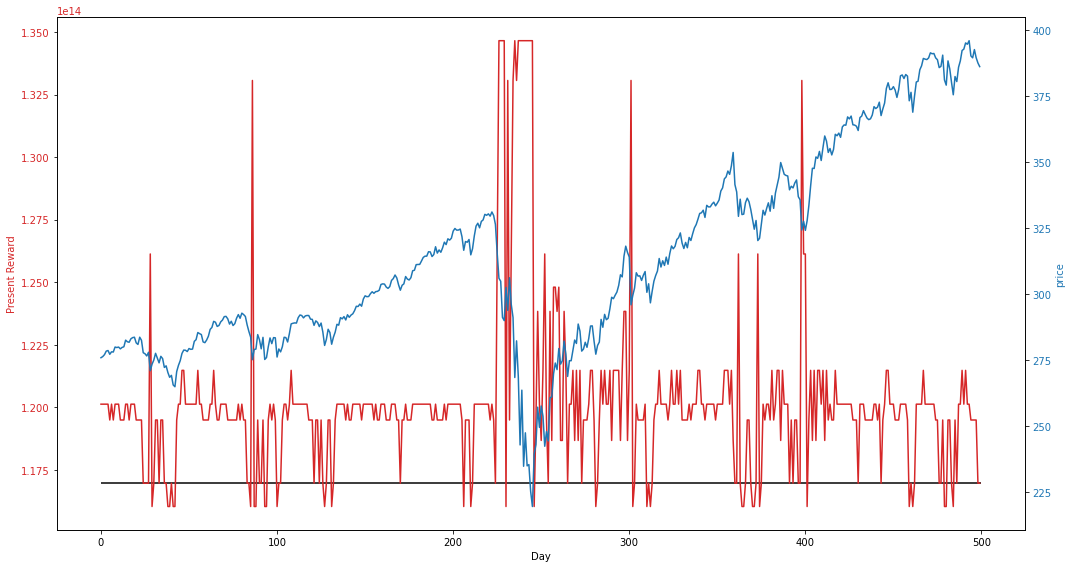

In [20]:
most_recent_days = 500

plt.rcParams["figure.figsize"] = (15,8)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Day')
ax1.set_ylabel('Present Reward', color=color)
ax1.plot(discounted_reward_distribution[-1*most_recent_days:], color=color)
ax1.tick_params(axis='y', labelcolor=color)

#a horizontal line according to the current level
ax1.hlines(discounted_reward_distribution[-1],0,len(discounted_reward_distribution[-1*most_recent_days:]),color = 'black')



ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('price', color=color)  # we already handled the x-label with ax1
ax2.plot(stock_raw_price[-1*most_recent_days:], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped


plt.show()